In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert_fine/pytorch/layer2/1/bert__lay2.pt
/kaggle/input/bert_fine/pytorch/_pt/1/bert.pt
/kaggle/input/bert_fine/pytorch/layer5/1/bert__lay5.pt
/kaggle/input/bert_fine/pytorch/layer1/1/bert1.pt
/kaggle/input/bert_fine/pytorch/layer0/1/bert0.pt
/kaggle/input/bert_fine/pytorch/layer4/1/bert__lay4.pt
/kaggle/input/bert_fine/pytorch/layer3/1/bert2.pt


In [3]:
!pip install datasets
!pip install transformers
!pip install tqdm

In [4]:
!pip install git+https://github.com/sissa-data-science/DADApy

  Cloning https://github.com/sissa-data-science/DADApy to /tmp/pip-req-build-qtyo29wj
  Running command git clone --filter=blob:none --quiet https://github.com/sissa-data-science/DADApy /tmp/pip-req-build-qtyo29wj
  Resolved https://github.com/sissa-data-science/DADApy to commit d61852a4aa41d27df508d2d2071f460e5cacef31
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dadapy: filename=dadapy-0.2.0-cp310-cp310-linux_x86_64.whl size=1934005 sha256=549376cde1b718ea6a9ff322efdcef3e72c4fa48b72d5e5c81a4c60a3b532694
  Stored in directory: /tmp/pip-ephem-wheel-cache-bxl_pnx2/wheels/56/5b/d0/089e78b70bafb936b8c3e513fb2671c66d5c19c219677cce57
Successfully built dadapy


In [5]:
import torch
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import BitsAndBytesConfig
from dadapy.data import Data
from matplotlib import pyplot as plt
import seaborn as sns

# Set device
torch.set_default_device("cuda")

# Load pre-trained model and tokenizer
model_name = "distilbert/distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name,
                                          add_eos_token=True,
                                          trust_remote_code=True)

tokenizer.pad_token = '[PAD]'
tokenizer.truncation_side = "right"

# Load dataset
dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset", split="train[:4500]")


# Function that tokenizes the text
def tokenize(rows):
    # Retrieve Text
    if rows["text"][0] is None:
        text = ""
    else:
        text = rows["text"][0].replace('"', r'\"')

    # Tokenize 
    encoded = tokenizer(
          text,
          add_special_tokens=True,
          max_length=260,
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
          padding='max_length',
        ).to("cuda")


    return encoded

# Applying tokenization to the dataset
tokenized_dataset = dataset.map(tokenize,
                                batched=True,
                                batch_size=1,
                                remove_columns=["id", "text", "label", "sentiment"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [6]:
model = DistilBertModel.from_pretrained(model_name, device_map="cuda")
model.load_state_dict(torch.load('/kaggle/input/bert_fine/pytorch/layer4/1/bert__lay4.pt'))


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<All keys matched successfully>

In [8]:
from transformers import DistilBertConfig
new_config = DistilBertConfig()
model = DistilBertModel(new_config)

In [9]:
# Constants
import gc
torch.cuda.empty_cache()
gc.collect()
num_data = 4500
per_batch = 50
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        del outputs
        torch.cuda.empty_cache()
        gc.collect()
        hidden_layers.append(liste)
del liste

100%|██████████| 90/90 [15:29<00:00, 10.33s/it]


In [10]:
# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []

for j in range(7):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(768)
        

# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

In [11]:
gc.collect()

0

No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 0: 114.01642193070097
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 1: 50.31544656799581
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 2: 47.12056449267668
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 3: 47.29143721778216
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 4: 47.3718781456631
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 5: 48.04560204318145
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 6: 48.71887075724665


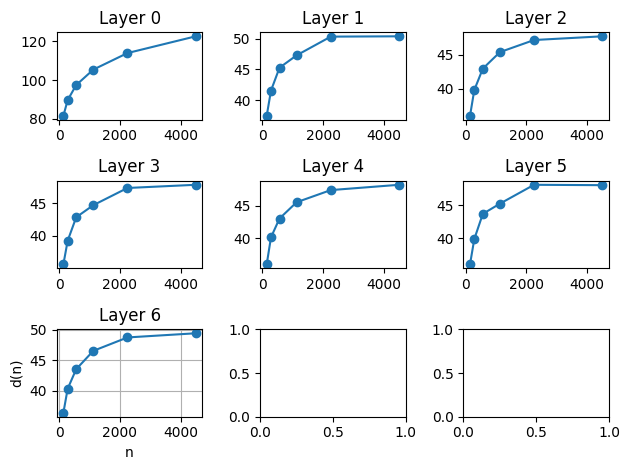

<Figure size 640x480 with 0 Axes>

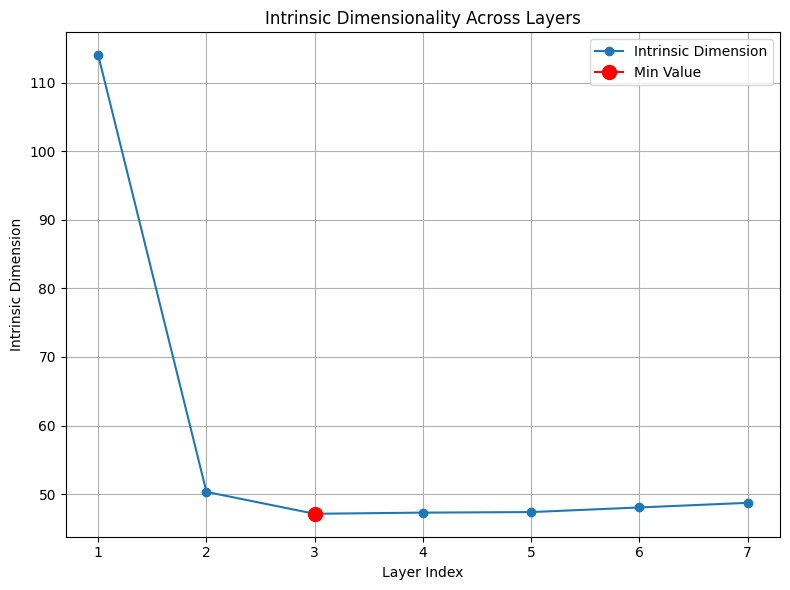

<Figure size 640x480 with 0 Axes>

In [12]:

# Compute intrinsic dimensions
intrinsic_dims = []

# Check which id to pick
fig, axes = plt.subplots(3, 3)

# # Flatten the axes array for easy iteration
axes = axes.flatten()

# n = len(id_list_2NN)
# ax = axes[i]
# ax.plot([per_batch * number_batches / 2**i for i in range(n)], id_list_2NN,  marker='o')
# ax.set_title(f'Figure {i+1}')
# ax.set_xlabel('n')
# ax.set_ylabel('d(n)')
# ax.grid(True)
# plt.tight_layout()
# plt.show()
# plt.savefig('ids_n.png')

for i in range(0, 7):
    X = hidden_layers_stacked[i].numpy()
    data = Data(X)
    data.remove_identical_points()
    data.remove_identical_points()
    #id_list_2NN, _, _ = data.return_id_scaling_2NN()
    id_list_2NN, _, _ = data.return_id_scaling_gride()
    n = len(id_list_2NN)
    ax = axes[i]
    ax.plot([per_batch * number_batches / 2**j for j in range(n)], id_list_2NN,  marker='o')
    ax.set_title(f'Layer {i}')
    intrinsic_dims.append(id_list_2NN[1])
    print(f"Intrinsic dimension for layer {i}: {id_list_2NN[1]}")
    
ax.set_xlabel('n')
ax.set_ylabel('d(n)')
ax.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('ids_n.png')

# Plot results
# Find the index of the minimum value
min_index = intrinsic_dims.index(min(intrinsic_dims)) + 1

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 8), intrinsic_dims, marker='o', linestyle='-', label='Intrinsic Dimension')
plt.plot(min_index, min(intrinsic_dims), marker='o', color='red', markersize=10, label='Min Value')
plt.title('Intrinsic Dimensionality Across Layers')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 8))
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("optimizing_layer4.png")


In [10]:
torch.cuda.empty_cache()

In [11]:
import gc
gc.collect()

4112

In [13]:
model = DistilBertModel.from_pretrained(model_name, device_map="cuda")

In [14]:
# Constants
import gc
torch.cuda.empty_cache()
gc.collect()
num_data = 4500
per_batch = 50
number_batches = num_data // per_batch

# Collect hidden layers
hidden_layers = []

# Collect hidden layers per batch
for batch in tqdm(range(number_batches)):
    for i in range(per_batch):
        # Extract inputs from the dataset using the tokenizer
        inputs = {k: torch.tensor(v).unsqueeze(0).to("cuda") for k, v in tokenized_dataset[batch * per_batch + i].items()}

        # Perform forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Append the hidden states to the list
        liste = list(map(lambda x: x.to('cpu'), outputs.hidden_states))
        del outputs
        torch.cuda.empty_cache()
        gc.collect()
        hidden_layers.append(liste)
del liste

100%|██████████| 90/90 [16:39<00:00, 11.10s/it]


In [22]:
# Move back to CPU
torch.set_default_device("cpu")

# Process hidden layers
hidden_layers_avg = []

for j in range(7):
    avg_batch_layer = []
    for i in range(number_batches * per_batch):
        layer = hidden_layers[i][j].detach().cpu()
        avg_batch_layer.append(torch.mean(layer.squeeze(dim=0), dim=0))
    hidden_layers_avg.append(avg_batch_layer)

# Handle empty tensors
for layer in hidden_layers_avg:
    for idx, tensor in enumerate(layer):
        if tensor.shape == torch.Size([]):
            print("Encountered empty tensor. Filling with zeros.")
            layer[idx] = torch.zeros(768)
        

# Stack hidden layers
hidden_layers_stacked = [torch.stack(layer) for layer in hidden_layers_avg]
hidden_layers_stacked = torch.stack(hidden_layers_stacked)

No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 0: 28.578906401758985
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 1: 23.301498269969102
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 2: 23.89740506371369
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 3: 23.635757291150483
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 4: 27.106722449881055
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 5: 27.619642315202356
No identical identical points were found
No identical identical points were found
Intrinsic dimension for layer 6: 26.124813219360163


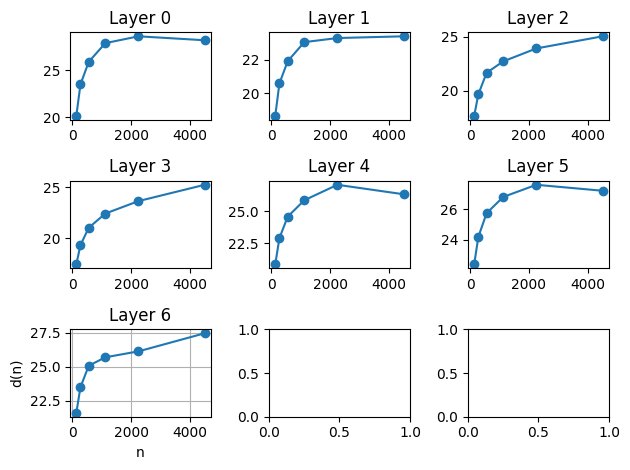

<Figure size 640x480 with 0 Axes>

In [24]:

# Compute intrinsic dimensions
intrinsic_dims_2 = []

# Check which id to pick
fig, axes = plt.subplots(3, 3)

# # Flatten the axes array for easy iteration
axes = axes.flatten()

# n = len(id_list_2NN)
# ax = axes[i]
# ax.plot([per_batch * number_batches / 2**i for i in range(n)], id_list_2NN,  marker='o')
# ax.set_title(f'Figure {i+1}')
# ax.set_xlabel('n')
# ax.set_ylabel('d(n)')
# ax.grid(True)
# plt.tight_layout()
# plt.show()
# plt.savefig('ids_n.png')

for i in range(0, 7):
    X = hidden_layers_stacked[i].numpy()
    data = Data(X)
    data.remove_identical_points()
    data.remove_identical_points()
    #id_list_2NN, _, _ = data.return_id_scaling_2NN()
    id_list_2NN, _, _ = data.return_id_scaling_gride()
    n = len(id_list_2NN)
    ax = axes[i]
    ax.plot([per_batch * number_batches / 2**j for j in range(n)], id_list_2NN,  marker='o')
    ax.set_title(f'Layer {i}')
    intrinsic_dims_2.append(id_list_2NN[1])
    print(f"Intrinsic dimension for layer {i}: {id_list_2NN[1]}")
    
ax.set_xlabel('n')
ax.set_ylabel('d(n)')
ax.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('ids_n.png')

# Plot results
# Find the index of the minimum value
min_index_2 = intrinsic_dims_2.index(min(intrinsic_dims_2)) + 1


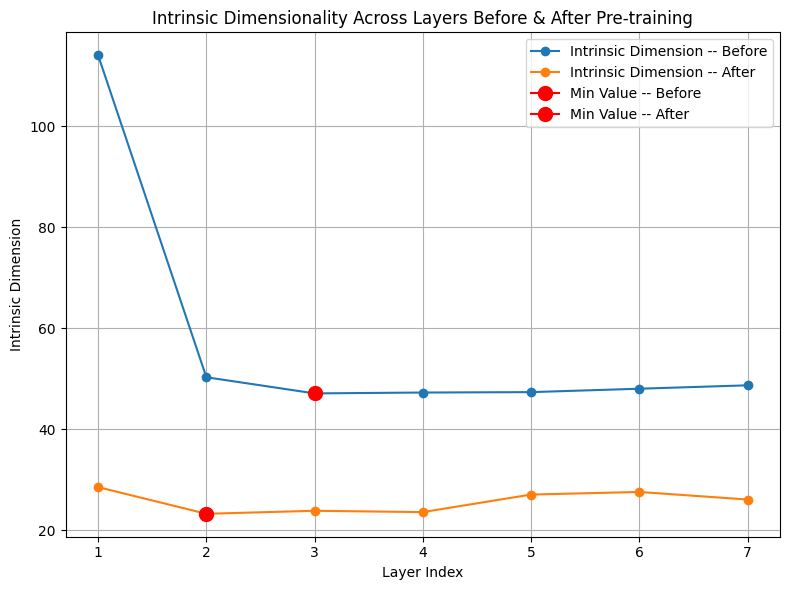

In [26]:
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 8), intrinsic_dims, marker='o', linestyle='-', label='Intrinsic Dimension -- Before')
plt.plot(np.arange(1, 8), intrinsic_dims_2, marker='o', linestyle='-', label='Intrinsic Dimension -- After')
plt.plot(min_index, min(intrinsic_dims), marker='o', color='red', markersize=10, label='Min Value -- Before')
plt.plot(min_index_2, min(intrinsic_dims_2), marker='o', color='red', markersize=10, label='Min Value -- After')
plt.title('Intrinsic Dimensionality Across Layers Before & After Pre-training')
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension')
plt.grid(True)
plt.xticks(np.arange(1, 8))
plt.legend()
plt.tight_layout()
plt.savefig("figure.png")
plt.show()



In [29]:
from transformers import TFDistilBertForSequenceClassification
model =  TFDistilBertForSequenceClassification.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [43]:
print(model.weights)

[<tf.Variable 'tf_distil_bert_for_sequence_classification/distilbert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32, numpy=
array([[-0.02, -0.07, -0.02, ..., -0.02, -0.05, -0.03],
       [-0.01, -0.07, -0.02, ..., -0.02, -0.06, -0.03],
       [-0.02, -0.07, -0.01, ..., -0.02, -0.06, -0.02],
       ...,
       [-0.02, -0.06, -0.01, ..., -0.02, -0.03, -0.02],
       [-0.05, -0.06, -0.  , ..., -0.01, -0.02, -0.02],
       [-0.01, -0.09, -0.  , ..., -0.02, -0.05,  0.05]], dtype=float32)>, <tf.Variable 'tf_distil_bert_for_sequence_classification/distilbert/embeddings/position_embeddings/embeddings:0' shape=(512, 768) dtype=float32, numpy=
array([[ 1.75e-02, -2.56e-02, -3.66e-02, ...,  3.34e-05,  6.83e-04,
         1.54e-02],
       [ 7.76e-03,  2.26e-03, -1.94e-02, ...,  2.89e-02,  2.98e-02,
        -5.32e-03],
       [-1.13e-02, -1.96e-03, -1.16e-02, ...,  1.49e-02,  1.87e-02,
        -7.31e-03],
       ...,
       [ 1.74e-02,  3.49e-03, -9.56e-03, ...,  2.96e-03,  4

In [ ]:
add_metric